In [6]:
from time import sleep
from selenium import webdriver
from string import punctuation
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import copy
import matplotlib.pyplot as plt
%pylab inline
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


C:\Users\bandi\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 1& 2.) Fetching 5000 posts from Edmunds.com luxury forum

In [155]:
driver = webdriver.Chrome('C:/Users/bandi/Desktop/Text Analytics/TA Session/chromedriver_win32/chromedriver')
driver.get('https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p702')

In [156]:
#Creating empty data frame to store user_id, dates and comments from ~5K users.
comments = pd.DataFrame(columns = ['Date','user_id','comments'])

j = 702
while (j>=1):
    # Running while loop only till we get 5K comments 
    if (len(comments)<5000):
        url = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p' + str(j)
        driver.get(url)
        ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
        comment_ids = []
        for i in ids:
            comment_ids.append(i.get_attribute('id'))

        for x in comment_ids:
            #Extract dates from for each user on a page
            user_date = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
            date = user_date.get_attribute('title')

            #Extract user ids from each user on a page
            user_title = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[1]/span[1]/a[1]')[0]
            userid = user_title.get_attribute('title') 

            #Extract Message for each user on a page
            user_message = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]')[0]
            comment = user_message.text
            
            #Extracting Block Quote if Present
            block_quote = driver.find_element_by_xpath('//*[@id="' + x + '"]/div/div[3]/div/div[1]')
            block_quote_class = block_quote.find_elements_by_class_name('UserQuote')
            block_text = ''
            if len(block_quote_class)>0:
                block_text = block_quote_class[0].text
            
            #Replacing block quotes
            comment = comment.replace(block_text,"")
            
           #Adding date, userid and comment for each user in a dataframe    
            comments.loc[len(comments)] = [date,userid,comment]
        j=j-1
    else:
        break
        

In [157]:
import copy
comments_copy = copy.deepcopy(comments)

def remove_space(s):
    return s.replace("\n"," ")
comments_copy['comments'] = comments_copy['comments'].apply(remove_space)

comments_copy.to_csv('comments.csv', header=True, sep=',') 

### Cleansing the posts we fetched from Edmunds.com

In [158]:
comments_copy = pd.read_csv('comments.csv')
comments_copy = comments_copy.dropna()
comments_copy.reset_index(inplace  = True)

In [159]:
def removepunc(item):
    for p in punctuation:
        item = item.lstrip().replace(p,'')
    return item

def lowerize(x):
    return x.lower()

comments_copy['comments_clean'] = comments_copy['comments'].apply(removepunc).apply(lowerize)

In [160]:
models = pd.read_csv("models.csv", header = None, names = ['brand','model'], encoding='windows-1252')

In [161]:
models['brand'] = models['brand'].apply(removepunc)

def model_to_brand(s):
    for i in models.index.values:
        s = s.replace(models["model"][i].lower(),models["brand"][i].lower())
    return s
comments_copy['comments_model_replace'] = comments_copy['comments_clean'].apply(model_to_brand)

In [162]:
comments_copy['comments_appear'] = comments_copy['comments_model_replace'].apply(word_tokenize).apply(set).apply(list)

# Remove stop words
stop_words = set(stopwords.words('english'))
def remove_stopwords(s):
    return [w for w in s if not w in stop_words] 
    
comments_copy['final_comments'] =  comments_copy['comments_appear'].apply(remove_stopwords)
#filtered_sentence = [w for w in temp['comments_appear'] if not w in stop_words]

In [163]:
count = []
for i in range(len(comments_copy)):
    count+=comments_copy['final_comments'][i]

In [164]:
from nltk import FreqDist
word_freq = nltk.FreqDist(count)

In [165]:
models_unique = models['brand'].drop_duplicates().tolist()

In [166]:
top_words = word_freq.most_common(500)
top_brands = []
for (key, items) in top_words:
    if key in models_unique:
        model_counts = (key,items)
        top_brands.append(model_counts)        

### 3. Top 10 brands 

In [211]:
top_15_brands_counts = top_brands[:15]
print ('Below are the top 10 brands along with their frequencies\n' , top_15_brands_counts[:10])

Below are the top 10 brands along with their frequencies
 [('bmw', 1353), ('audi', 1088), ('acura', 535), ('mercedes', 400), ('cadillac', 339), ('honda', 325), ('infiniti', 253), ('ford', 244), ('volkswagen', 229), ('lexus', 198)]


## Task A: Calculate lift ratios for associations between brands. Show the brands on a MDS map.

In [212]:
# Fetching the top 10 brands.
top_15_brands =[]
for brand, count in top_15_brands_counts:
    top_15_brands.append(brand)    

In [213]:
new_df = pd.DataFrame(columns = top_15_brands)

def brand_mentioned(item):
    if brand in item:
        return 1
    else:
        return 0
      
for brand in top_15_brands:
    new_df[brand] = comments_copy['final_comments'].apply(brand_mentioned)    

In [214]:
df2=pd.DataFrame(columns = top_15_brands)

for i in range(len(top_15_brands)):
    new_list = []
    for j in range(len(top_15_brands)):
        if (i!=j):
            lift = (((new_df[top_15_brands[i]] + new_df[top_15_brands[j]]) > 1).sum())/(new_df[top_15_brands[j]].sum()*new_df[top_15_brands[i]].sum())
            lift = lift*len(new_df)
            df2.loc[top_15_brands[i],top_15_brands[j]] = lift

In [215]:
print ('Below are the lift ratios between top brands\n')
df2

Below are the lift ratios between top brands



,bmw,audi,acura,mercedes,cadillac,honda,infiniti,ford,volkswagen,lexus,hyundai,kia,toyota,volvo,subaru
bmw,NaN,1.50198,1.37901,2.27786,1.62135,1.03288,1.85171,1.69324,1.17592,2.31018,1.39087,1.6366,1.23945,2.05661,1.09668
audi,1.50198,NaN,2.00641,2.51156,2.17864,1.65143,2.59283,1.14683,2.26361,2.68752,1.62937,1.19529,1.32115,2.27336,1.90105
acura,1.37901,2.00641,NaN,2.58879,2.14649,3.64548,4.24044,0.87937,1.38509,3.62793,1.17249,0.985455,1.71653,2.80695,1.34472
mercedes,2.27786,2.51156,2.58879,NaN,3.16538,1.91962,3.45227,1.73867,1.41666,5.3565,2.11367,1.66952,1.69694,4.19597,1.1241
cadillac,1.62135,2.17864,2.14649,3.16538,NaN,1.40432,3.49155,1.56881,1.02866,4.75886,2.09175,1.34785,1.76673,3.64811,1.59164
honda,1.03288,1.65143,3.64548,1.91962,1.40432,NaN,1.82098,1.63639,2.41419,2.55949,2.18186,2.59554,5.40564,0.815412,2.35196
infiniti,1.85171,2.59283,4.24044,3.45227,3.49155,1.82098,NaN,1.53614,1.80905,7.47245,2.04819,1.94494,2.36727,4.36444,2.84357
ford,1.69324,1.14683,0.87937,1.73867,1.56881,1.63639,1.53614,NaN,2.14375,1.54962,2.34729,3.16907,2.12731,1.81017,3.31701
volkswagen,1.17592,2.26361,1.38509,1.41666,1.02866,2.41419,1.80905,2.14375,NaN,1.54104,2.02465,1.68833,2.78973,1.92874,2.74889
lexus,2.31018,2.68752,3.62793,5.3565,4.75886,2.55949,7.47245,1.54962,1.54104,NaN,3.1681,3.19526,6.25135,5.57679,2.72509


### MDS plot

In [226]:
dissimilarity_matrix = 1/df2
np.fill_diagonal(dissimilarity_matrix.values, 0)

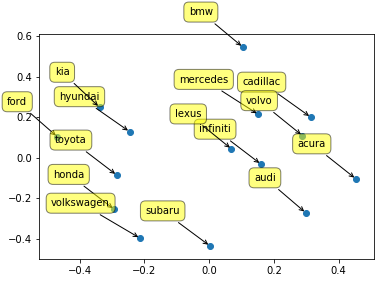

In [217]:
from sklearn import manifold
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
      random_state=seed, dissimilarity="precomputed", n_jobs=1)
results = mds.fit(dissimilarity_matrix)
coords = results.embedding_

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
for label, x, y in zip(top_15_brands, coords[:, 0], coords[:, 1]):
    
    plt.annotate(
        label,
        xy = (x, y), xytext = (-30, 30),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

### Task B: What insights can you offer brand managers from your analysis in Task A (choose two brands that you can offer the most interesting/useful insights for)? 

### Task C:
### i.) What are 5 most frequently mentioned attributes of cars in the discussions?

In [218]:
attributes = pd.read_csv('attributes.csv')

In [219]:
def word_to_attributes(s):
    s = " ".join(str(x) for x in s)
    for i in attributes.index.values:
        s = s.replace(attributes["Attribute"][i].lower(),attributes["Mapping"][i].lower())
    return s
comments_copy['comments_attributes_replace'] = comments_copy['final_comments'].apply(word_to_attributes)

In [220]:
count = []
for i in range(len(comments_copy)):
    count+=comments_copy['comments_attributes_replace'][i]
attr_freq = nltk.FreqDist(count)
attributes_unique = attributes['Mapping'].drop_duplicates().tolist()

top_words = word_freq.most_common(3000)
top_attributes = []
for (key, items) in top_words:
    if key in attributes_unique:
        attribute_counts = (key,items)
        top_attributes.append(attribute_counts) 

In [221]:
top_5_attributes_counts = top_attributes[:5]
print ('Below are the top 5 attributes along with their frequencies\n' , top_5_attributes_counts)

Below are the top 5 attributes along with their frequencies
 [('performance', 332), ('maintenance', 104), ('styling', 66), ('comfort', 53), ('safety', 47)]


### ii.) Which attributes are most strongly associated with which of the top 5 brands?

In [222]:
# Fetching top 5 attrbutes
top_5_attributes =[]
for attribute, count in top_5_attributes_counts:
    top_5_attributes.append(attribute) 

In [223]:
attributes_df = pd.DataFrame(columns = top_5_attributes)

def attribute_mentioned(item):
    if attribute in item:
        return 1
    else:
        return 0
      
for attribute in top_5_attributes:
    attributes_df[attribute] = comments_copy['comments_attributes_replace'].apply(attribute_mentioned)  

In [224]:
df3=pd.DataFrame(columns = top_5_attributes)
top_5_brands = top_15_brands[:5]
for i in range(len(top_5_brands)):
    new_list = []
    for j in range(len(top_5_attributes)):
        lift_brand_attributes = (((new_df[top_5_brands[i]] + attributes_df[top_5_attributes[j]]) > 1).sum())/(new_df[top_5_brands[i]].sum()*attributes_df[top_5_attributes[j]].sum())
        lift_brand_attributes = lift_brand_attributes*len(attributes_df)
        df3.loc[top_5_brands[i],top_5_attributes[j]] = lift_brand_attributes

In [225]:
print ('Below are the lift ratios between top 5 brands and top 5 attributes \n')
df3

Below are the lift ratios between top 5 brands and top 5 attributes 



,performance,maintenance,styling,comfort,safety
bmw,1.39263,1.41275,1.52248,1.47226,1.26055
audi,1.54418,1.56977,1.98506,1.80543,1.64451
acura,1.51728,1.58791,2.28984,1.9444,1.68195
mercedes,1.28526,1.17253,1.81491,2.14414,1.04633
cadillac,1.16098,1.2791,1.25812,1.94235,1.26547


### iii.) While BMW has claimed that they are the “ultimate driving machine”, is that how people feel on Edmunds? 

The association of bmw with performance is lower than that of audi or acura with bmw. This shows that probably people don't associate bmw with performace that much. However, what would be interesting to look into is whether the association between bmw and performance is positive (positive sentiment), while the same with acura is negative (negative sentiment). What is interesting is that people associate bmw more with comfort, styling and maintenance than performance. 

## Task D: What advice will you give to a (i) product manager, and (ii) marketing/advertising manager of these brands based on your analysis in Task C? For this assignment, you can assume the sentiment (e.g., that it is positive)